In [1]:
import sqlite3 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import confusion_matrix 
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc 
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



# Loading and Sampling the dataset(100k data-points)

In [0]:
final = pd.read_csv("final.csv")


final_data = final.sample(n = 100000)

final_data = final_data.drop(["Text"], axis = 1)
final_data = final_data.drop(final_data.columns[0], axis = 1)

In [0]:
labels = final_data.Score
final_data = final_data.sort_values("Time")
final_data.shape

(100000, 10)

# Train/Test Split

In [0]:
n = final_data.shape[0]
train_size = 0.7

train_set = final_data.iloc[:int(n*train_size)]
test_set =final_data.iloc[int(n*train_size):]

X_train = train_set.CleanedText
y_train = train_set.Score

X_test = test_set.CleanedText
y_test= test_set.Score

In [0]:
## tokenizing the training data to find frequency of words
t = []
for line in X_train:
    l = nltk.word_tokenize(line)
    for w in l:
        t.append(w)

In [0]:
word_features = nltk.FreqDist(t)
print (len(word_features))

36299


# Feature Selection

In [0]:
#The most frequent 5000 features as the featureset

topwords = [fpair[0] for fpair in list(word_features.most_common(5000))]
print (word_features.most_common(25))

[("'", 69999), ('like', 30800), ('tast', 30378), ('flavor', 24481), ('good', 23182), ('one', 21533), ('product', 20781), ('use', 20744), ('tea', 19030), ('great', 19021), ('tri', 18764), ('love', 18374), ('coffe', 17075), ('get', 16219), ('make', 16114), ('food', 14288), ('would', 13576), ('buy', 12549), ('time', 12343), ('amazon', 11952), ('eat', 11543), ('realli', 10904), ('price', 10670), ('much', 10596), ('find', 10563)]


In [0]:
word_plot = pd.DataFrame(word_features.most_common(25),columns=['Word','Count'])

In [0]:
print(word_plot)

       Word  Count
1      like  30800
2      tast  30378
3    flavor  24481
4      good  23182
5       one  21533
6   product  20781
7       use  20744
8       tea  19030
9     great  19021
10      tri  18764
11     love  18374
12    coffe  17075
13      get  16219
14     make  16114
15     food  14288
16    would  13576
17      buy  12549
18     time  12343
19   amazon  11952
20      eat  11543
21   realli  10904
22    price  10670
23     much  10596
24     find  10563


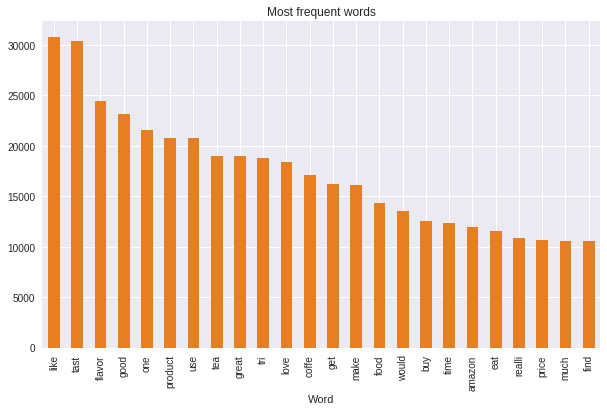

In [0]:
word_plot.plot(kind='bar',x=word_plot['Word'],legend=False,title='Most frequent words',figsize=(10,6), color = '#e67e22')

## We can observe from the above plot that the most important words are:
- **like**
- **taste**
- **flavour**

# Bag of words Vectorization

In [0]:
count_vect = CountVectorizer() #in scikit-learn
X_train1 = count_vect.fit_transform(X_train)
X_test1 = count_vect.transform(X_test)

In [0]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc= StandardScaler(with_mean=False) 
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



# GridSearch Cross-Validation

In [0]:
my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train1)]

param_grid  = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=my_cv)
grid.fit(X_train1, y_train)

GridSearchCV(cv=[(array([   0,    1, ..., 6368, 6369]), array([ 6370,  6371, ..., 12731, 12732])), (array([    0,     1, ..., 12731, 12732]), array([12733, 12734, ..., 19094, 19095])), (array([    0,     1, ..., 19094, 19095]), array([19096, 19097, ..., 25457, 25458])), (array([    0,     1, ..., 25457, 25458]),...635, 63636])), (array([    0,     1, ..., 63635, 63636]), array([63637, 63638, ..., 69998, 69999]))],
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.899
Best parameters:  {'C': 0.001}


# RandomizedSearch Cross-Validation

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats


my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train1)]

param_grid  = {"C": stats.uniform(0.001, 10)}
             

grid =  RandomizedSearchCV(LogisticRegression(), param_grid, cv=my_cv, n_iter = 10)
grid.fit(X_train1, y_train)

RandomizedSearchCV(cv=[(array([   0,    1, ..., 6368, 6369]), array([ 6370,  6371, ..., 12731, 12732])), (array([    0,     1, ..., 12731, 12732]), array([12733, 12734, ..., 19094, 19095])), (array([    0,     1, ..., 19094, 19095]), array([19096, 19097, ..., 25457, 25458])), (array([    0,     1, ..., 25457, 25458]),...635, 63636])), (array([    0,     1, ..., 63635, 63636]), array([63637, 63638, ..., 69998, 69999]))],
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fccc10bfcf8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_sco

In [0]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.869
Best parameters:  {'C': 0.6203520096925298}


# Applying Logistic Regression

In [0]:
logreg = LogisticRegression(C = 0.001).fit(X_train1, y_train)


print("Training set score: {:.3f}".format(logreg.score(X_train1, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test1, y_test)))

Training set score: 0.970
Test set score: 0.901


# Generating a Confusion matrix

In [0]:
y_pred = logreg.predict(X_test1)

log_cfm = confusion_matrix(y_test, y_pred)

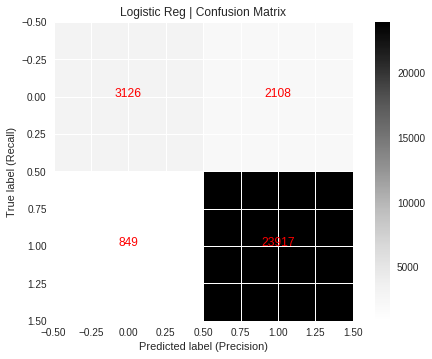

In [0]:
import itertools    

plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="red")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
plt.colorbar();

# Comparing 'L1' and 'L2' regularization techniques

In [0]:
for i, C in enumerate((0.001, 0.01, 0.1, 1)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
    clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01)
    clf_l1_LR.fit(X_train1, y_train)
    clf_l2_LR.fit(X_train1, y_train)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%.3f" % C)
    print("Sparsity with L1 penalty: %.3f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(X_train1, y_train))
    print("Sparsity with L2 penalty: %.3f%%" % sparsity_l2_LR)
    print("score with L2 penalty: %.4f" % clf_l2_LR.score(X_train1, y_train))



C=0.001
Sparsity with L1 penalty: 99.759%
score with L1 penalty: 0.8743
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.9695
C=0.010
Sparsity with L1 penalty: 88.691%
score with L1 penalty: 0.9404
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.9805
C=0.100
Sparsity with L1 penalty: 65.301%
score with L1 penalty: 0.9767
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.9856
C=1.000
Sparsity with L1 penalty: 52.631%
score with L1 penalty: 0.9848
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.9872


|| Hyper-parameter| Sparsity | Score |
|---| --- | --- | --- |
|L1-regularizer| 0.001 | 99.7 % |0 .87 |
|L2-regularizer| 0.001 | 0 % | 0.96|
| --- | --- | --- | --- |
|L1-regularizer| 0.01 | 88.6% |0 .94 |
|L2-regularizer| 0.01 | 0 % | 0.98|
| --- | --- | --- | --- |
|L1-regularizer| 0.1| 65.3% | 0.97 |
|L2-regularizer| 0.1 | 0 % | 0.98|
| --- | --- | --- | --- |
|L1-regularizer| 1.0| 52.6% | 0.98 |
|L2-regularizer| 1.0 | 0 % | 0.98|


# TF-idf Vectorization

In [0]:
#TF-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train2 = tf_idf_vect.fit_transform(X_train)
X_test2 = tf_idf_vect.transform(X_test)

In [0]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc= StandardScaler(with_mean=False) 
X_train2 = sc.fit_transform(X_train2)
X_test2 = sc.transform(X_test2)

# Applying GridSearch CV

In [0]:
my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train2)]

param_grid  = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=my_cv)
grid.fit(X_train2, y_train)

GridSearchCV(cv=[(array([   0,    1, ..., 6368, 6369]), array([ 6370,  6371, ..., 12731, 12732])), (array([    0,     1, ..., 12731, 12732]), array([12733, 12734, ..., 19094, 19095])), (array([    0,     1, ..., 19094, 19095]), array([19096, 19097, ..., 25457, 25458])), (array([    0,     1, ..., 25457, 25458]),...635, 63636])), (array([    0,     1, ..., 63635, 63636]), array([63637, 63638, ..., 69998, 69999]))],
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.857
Best parameters:  {'C': 10}


# Applying RandomizedSearch CV

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats


my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train2)]

param_grid  = {"C": stats.uniform(0.001, 10)}
             

grid =  RandomizedSearchCV(LogisticRegression(), param_grid, cv=my_cv, n_iter = 10)
grid.fit(X_train2, y_train)

RandomizedSearchCV(cv=[(array([   0,    1, ..., 6368, 6369]), array([ 6370,  6371, ..., 12731, 12732])), (array([    0,     1, ..., 12731, 12732]), array([12733, 12734, ..., 19094, 19095])), (array([    0,     1, ..., 19094, 19095]), array([19096, 19097, ..., 25457, 25458])), (array([    0,     1, ..., 25457, 25458]),...635, 63636])), (array([    0,     1, ..., 63635, 63636]), array([63637, 63638, ..., 69998, 69999]))],
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fccbb5f36d8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_scor

In [0]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.857
Best parameters:  {'C': 1.9773164474979121}


In [0]:
logreg = LogisticRegression(C = 10.0).fit(X_train2, y_train)


print("Training set score: {:.3f}".format(logreg.score(X_train2, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test2, y_test)))

Training set score: 1.000
Test set score: 0.864


# Generating Confusion matrix

In [0]:
y_pred = logreg.predict(X_test2)

log_cfm = confusion_matrix(y_test, y_pred)

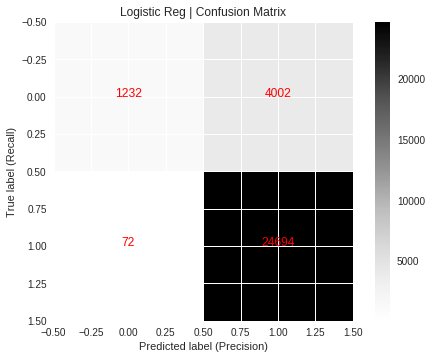

In [0]:
import itertools    

plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="red")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
plt.colorbar();

In [0]:
for i, C in enumerate((0.001, 0.01, 0.1, 1)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
    clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01)
    clf_l1_LR.fit(X_train2, y_train)
    clf_l2_LR.fit(X_train2, y_train)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%.3f" % C)
    print("Sparsity with L1 penalty: %.3f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(X_train2, y_train))
    print("Sparsity with L2 penalty: %.3f%%" % sparsity_l2_LR)
    print("score with L2 penalty: %.4f" % clf_l2_LR.score(X_train2, y_train))



C=0.001
Sparsity with L1 penalty: 99.992%
score with L1 penalty: 0.8777
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 1.0000
C=0.010
Sparsity with L1 penalty: 97.911%
score with L1 penalty: 0.9996
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 1.0000
C=0.100
Sparsity with L1 penalty: 94.378%
score with L1 penalty: 1.0000
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 1.0000
C=1.000
Sparsity with L1 penalty: 85.909%
score with L1 penalty: 1.0000
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 1.0000


|| Hyper-parameter| Sparsity | Score |
|---| --- | --- | --- |
|L1-regularizer| 0.001 | 99.9 % |0.87 |
|L2-regularizer| 0.001 | 0 % | 1.0 |
| --- | --- | --- | --- |
|L1-regularizer| 0.01 | 97.9% |0.99 |
|L2-regularizer| 0.01 | 0 % | 1.0 |
| --- | --- | --- | --- |
|L1-regularizer| 0.1 | 94.3% | 1.0|
|L2-regularizer| 0.1 | 0 % | 1.0 |
| --- | --- | --- | --- |
|L1-regularizer| 1.0 | 85.9% | 1.0 |
|L2-regularizer| 1.0 | 0 % | 1.0 |


# Word2Vec Vectorization

In [5]:
import nltk
nltk.download('stopwords')
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{"that'll", 'his', 've', 'we', 'how', 'about', 'some', 'didn', 'an', 'for', 'y', 'down', "couldn't", 'in', 'he', 'can', 'me', 'isn', 'couldn', "mustn't", 'needn', 'my', 'few', 'so', 'was', 'than', 'having', 'very', 'o', 're', 'here', 'being', "won't", "doesn't", 'she', 'your', "she's", 'is', 'which', 'same', 'weren', 'there', 't', 'but', 'itself', 'up', 'nor', 'whom', 'until', 'between', 'doesn', 'yourselves', "you'd", 'ours', 'yours', 'only', 'more', 'any', 'hasn', 'll', "didn't", "wasn't", 'that', 'won', "don't", 'doing', 'above', 'these', 'those', 'all', 'd', 'a', "wouldn't", 'will', 'shan', 'why', "you're", 'after', 'myself', 'with', 's', 'too', 'now', 'they', 'should', 'mustn', "aren't", 'hers', 'each', 'because', 'i', 'm', 'during', 'shouldn', 'our', 'did', 'when', 'haven', 'by', 'further', "shouldn't", 'just', "hadn't", 'below', 'over', 'him', 'ma', 'if', 'ai

##  ***Training Word2Vec model using own text corpus***


In [0]:
import gensim
i=0
train_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    train_sent.append(filtered_sentence)
    

In [0]:

test_sent=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    test_sent.append(filtered_sentence)

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=gensim.models.Word2Vec(train_sent,min_count=5,size=50, workers=4)    


# Applying Average Word2vec

In [0]:
#AVG-W2V
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in train_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [0]:
#AVG-W2V
sent_vectors2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in test_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors2.append(sent_vec)
print(len(sent_vectors2))
print(len(sent_vectors2[0]))

30000
50


In [0]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc= StandardScaler(with_mean=False) 
X_train3 = sc.fit_transform(sent_vectors)
X_test3 = sc.transform(sent_vectors2)

# Applying GridSearch CV

In [0]:
my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train3)]

param_grid  = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=my_cv)
grid.fit(X_train3, y_train)

GridSearchCV(cv=[(array([   0,    1, ..., 6368, 6369]), array([ 6370,  6371, ..., 12731, 12732])), (array([    0,     1, ..., 12731, 12732]), array([12733, 12734, ..., 19094, 19095])), (array([    0,     1, ..., 19094, 19095]), array([19096, 19097, ..., 25457, 25458])), (array([    0,     1, ..., 25457, 25458]),...635, 63636])), (array([    0,     1, ..., 63635, 63636]), array([63637, 63638, ..., 69998, 69999]))],
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.887
Best parameters:  {'C': 0.1}


# Applying Randomized CV

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats


my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train3)]

param_grid  = {"C": stats.uniform(0.001, 10)}
             

grid =  RandomizedSearchCV(LogisticRegression(), param_grid, cv=my_cv, n_iter = 10)
grid.fit(X_train3, y_train)

RandomizedSearchCV(cv=[(array([   0,    1, ..., 6368, 6369]), array([ 6370,  6371, ..., 12731, 12732])), (array([    0,     1, ..., 12731, 12732]), array([12733, 12734, ..., 19094, 19095])), (array([    0,     1, ..., 19094, 19095]), array([19096, 19097, ..., 25457, 25458])), (array([    0,     1, ..., 25457, 25458]),...635, 63636])), (array([    0,     1, ..., 63635, 63636]), array([63637, 63638, ..., 69998, 69999]))],
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcca9f49160>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_scor

In [0]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.887
Best parameters:  {'C': 5.16712437106295}


In [0]:
logreg = LogisticRegression(C = 0.1).fit(X_train3, y_train)


print("Training set score: {:.3f}".format(logreg.score(X_train3, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test3, y_test)))

Training set score: 0.891
Test set score: 0.877


# Generating Confusion matrix

In [0]:
y_pred = logreg.predict(X_test3)

log_cfm = confusion_matrix(y_test, y_pred)

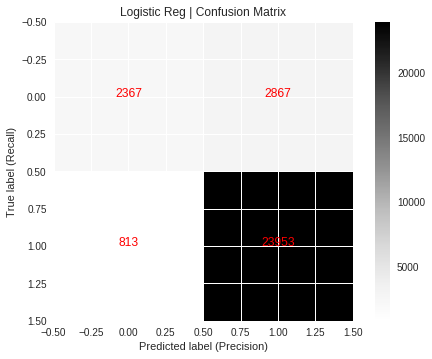

In [0]:
import itertools    

plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="red")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
plt.colorbar();

In [0]:
for i, C in enumerate((0.001, 0.01, 0.1, 1)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
    clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01)
    clf_l1_LR.fit(X_train3, y_train)
    clf_l2_LR.fit(X_train3, y_train)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%.3f" % C)
    print("Sparsity with L1 penalty: %.3f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(X_train3, y_train))
    print("Sparsity with L2 penalty: %.3f%%" % sparsity_l2_LR)
    print("score with L2 penalty: %.4f" % clf_l2_LR.score(X_train3, y_train))



C=0.001
Sparsity with L1 penalty: 60.000%
score with L1 penalty: 0.8749
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.8885
C=0.010
Sparsity with L1 penalty: 14.000%
score with L1 penalty: 0.8900
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.8911
C=0.100
Sparsity with L1 penalty: 0.000%
score with L1 penalty: 0.8910
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.8913
C=1.000
Sparsity with L1 penalty: 0.000%
score with L1 penalty: 0.8909
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.8913


|| Hyper-parameter| Sparsity | Score |
|---| --- | --- | --- |
|L1-regularizer| 0.001 | 60 % |0 .87 |
|L2-regularizer| 0.001 | 0 % | 0.88 |
| --- | --- | --- | --- |
|L1-regularizer| 0.01 | 14 % | 0.89 |
|L2-regularizer| 0.01 | 0 % | 0.89|
| --- | --- | --- | --- |
|L1-regularizer| 0.1 | 0 % | 0.89|
|L2-regularizer| 0.1 | 0 % | 0.89 |
| --- | --- | --- | --- |
|L1-regularizer| 1.0 | 0% | 0.89 |
|L2-regularizer| 1.0 | 0 % | 0.89 |


# Word2Vec Tf-idf Vectorization

In [0]:
#TF-IDF

tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_train)
tfidf_feat = tf_idf_vect.get_feature_names()
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in train_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
            
            
        except:
            pass

    sent_vec /= weight_sum
    #print(np.isnan(np.sum(sent_vec)))

    train_vectors.append(sent_vec)
    row += 1

In [0]:
#TF-IDF

tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_test)
tfidf_feat = tf_idf_vect.get_feature_names()
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in test_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
            
            
        except:
            pass

    sent_vec /= weight_sum
    #print(np.isnan(np.sum(sent_vec)))

    test_vectors.append(sent_vec)
    row += 1

In [0]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc= StandardScaler(with_mean=False) 
X_train4 = sc.fit_transform(train_vectors)
X_test4 = sc.transform(test_vectors)

# Applying GridSearch CV

In [16]:
my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train4)]

param_grid  = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=my_cv)
grid.fit(X_train4, y_train)

GridSearchCV(cv=[(array([  0,   1, ..., 638, 639]), array([ 640,  641, ..., 1274, 1275])), (array([   0,    1, ..., 1274, 1275]), array([1276, 1277, ..., 1910, 1911])), (array([   0,    1, ..., 1910, 1911]), array([1912, 1913, ..., 2546, 2547])), (array([   0,    1, ..., 2546, 2547]), array([2548, 2549, ..., 318...9, ..., 6362, 6363])), (array([   0,    1, ..., 6362, 6363]), array([6364, 6365, ..., 6998, 6999]))],
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.850
Best parameters:  {'C': 10}


# Applying RandomizedSearch CV

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats


my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train4)]

param_grid  = {"C": stats.uniform(0.001, 10)}
             

grid =  RandomizedSearchCV(LogisticRegression(), param_grid, cv=my_cv, n_iter = 10)
grid.fit(X_train4, y_train)

RandomizedSearchCV(cv=[(array([  0,   1, ..., 638, 639]), array([ 640,  641, ..., 1274, 1275])), (array([   0,    1, ..., 1274, 1275]), array([1276, 1277, ..., 1910, 1911])), (array([   0,    1, ..., 1910, 1911]), array([1912, 1913, ..., 2546, 2547])), (array([   0,    1, ..., 2546, 2547]), array([2548, 2549, ..., 318...9, ..., 6362, 6363])), (array([   0,    1, ..., 6362, 6363]), array([6364, 6365, ..., 6998, 6999]))],
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efc5f20ef60>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_scor

In [19]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.850
Best parameters:  {'C': 9.080485889967418}


In [20]:
logreg = LogisticRegression(C = 10).fit(X_train4, y_train)


print("Training set score: {:.3f}".format(logreg.score(X_train4, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test4, y_test)))

Training set score: 0.858
Test set score: 0.825


# Generating Confusion matrix

In [0]:
y_pred = logreg.predict(X_test4)

log_cfm = confusion_matrix(y_test, y_pred)

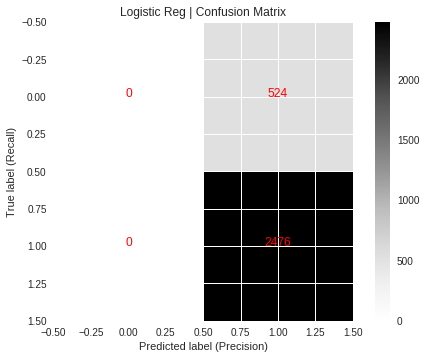

In [22]:
import itertools    

plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="red")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
plt.colorbar();

In [23]:
for i, C in enumerate((0.001, 0.01, 0.1, 1,10.0)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
    clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01)
    clf_l1_LR.fit(X_train4, y_train)
    clf_l2_LR.fit(X_train4, y_train)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%.3f" % C)
    print("Sparsity with L1 penalty: %.3f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(X_train4, y_train))
    print("Sparsity with L2 penalty: %.3f%%" % sparsity_l2_LR)
    print("score with L2 penalty: %.4f" % clf_l2_LR.score(X_train4, y_train))



C=0.001
Sparsity with L1 penalty: 90.000%
score with L1 penalty: 0.8514
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.8516
C=0.010
Sparsity with L1 penalty: 80.000%
score with L1 penalty: 0.8514
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.8514
C=0.100
Sparsity with L1 penalty: 28.000%
score with L1 penalty: 0.8519
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.8520
C=1.000
Sparsity with L1 penalty: 0.000%
score with L1 penalty: 0.8516
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.8531
C=10.000
Sparsity with L1 penalty: 0.000%
score with L1 penalty: 0.8521
Sparsity with L2 penalty: 0.000%
score with L2 penalty: 0.8577


|| Hyper-parameter| Sparsity | Score |
|---| --- | --- | --- |
|L1-regularizer| 0.001 | 90% |0 .85 |
|L2-regularizer| 0.001 | 0 % | 0.85 |
| --- | --- | --- | --- |
|L1-regularizer| 0.01 | 80% |0 .85 |
|L2-regularizer| 0.01 | 0 % | 0.85 |
| --- | --- | --- | --- |
|L1-regularizer| 0.1 | 28 % | 0.85 |
|L2-regularizer| 0.1 | 0 % | 0.85|
| --- | --- | --- | --- |
|L1-regularizer| 1.0| 0% | 0.85|
|L2-regularizer| 1.0 | 0 % | 0.85 |
| --- | --- | --- | --- |
|L1-regularizer| 10.0| 0% | 0.85|
|L2-regularizer| 10.0 | 0% | 0.85 |


# Conclusion
## The most important words are:
- ## **tast**
- ## **like**
- ## **product**

## Bag of Words:
- ### GridSearch CV
 - Best Parameter C = 0.001
 - CV Score = 0.854

- ### RandomizedSearch CV
 - Best Parameter C = 0.54
 - CV Score = 0.796

- ## Test set score = 0.90
- ## Train set score = 0.97

## Tf-IDF:
- ### GridSearch CV
 - Best Parameter C = 0.001
 - CV Score = 0.824

- ### RandomizedSearch CV
 - Best Parameter C = 1.79
 - CV Score = 0.823

- ## Test set score = 0.86
- ## Train set score = 1.0

## Average Word2vec:
- ### GridSearch CV
 - Best Parameter C = 0.001
 - CV Score = 0.832

- ### RandomizedSearch CV
 - Best Parameter C = 4.27
 - CV Score = 0.831

- ## Test set score = 0.87
- ## Train set score = 0.89

## Word2vec-tfidf:
- ### GridSearch CV
 - Best Parameter C = 10.0
 - CV Score = 0.738

- ### RandomizedSearch CV
 - Best Parameter C = 8.42
 - CV Score = 0.737

- ## Test set score = 0.82
- ## Train set score = 0.85